# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

        анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
        контролировать добросовестность кассиров при продаже алкоголя.
        
Наша задача - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем  распоряжении набор фотографий людей с указанием возраста

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Found 5694 images belonging to 1 classes.
Found 1897 images belonging to 1 classes.


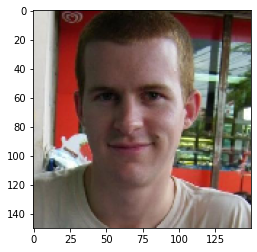

In [2]:
# < Перенесите сюда исследовательский анализ данных >

datagen = ImageDataGenerator(validation_split=0.25, rescale = (1/255))

train_datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345)

val_datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345)

a = next(train_datagen_flow)[0][0]

plt.imshow(a)


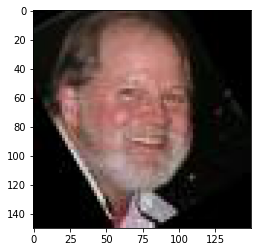

In [3]:
b = next(train_datagen_flow)[0][1]

plt.imshow(b)

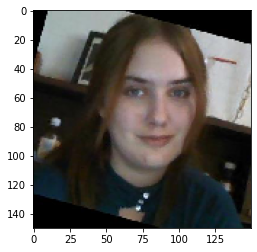

In [4]:
c = next(train_datagen_flow)[0][10]

plt.imshow(c)

Рассмотрим распределение по возрасту

In [5]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


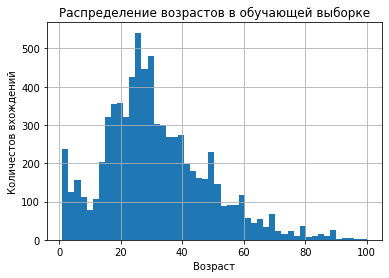

In [6]:
df['real_age'].hist(bins = 50)

plt.title('Распределение возрастов в обучающей выборке')
plt.xlabel('Возраст')
plt.ylabel('Количестов вхождений')
plt.show()

Распределение фотографий по возрастам не равномерное, есть 2 пика в младенческом возрасте и около 30 лет. 

Людей для распознавания в диапазоне от 18 до 40 лет сильно больше, чем людей посе 60-ти.

Пожилых (после 70) совсем мало.

### Анализ данных. Выоды

1. Для анадиза посупает более 7500 фотографий. 
2. Обучение модели будет усложняться следующими факторами:
        
        фотографии цветные
        на фотографиях присутсвует различный фон
        при номинально равном размере четкость у фотограий разная
        на некоторых присутсвует наклон
        не все лица расположены сторого по центру
        
3. Несмотря на то, что это подготовленный датасет, распределение фотографий по возрастам не равномерное. Людей для распознавания в диапазоне от 18 до 40 лет сильно больше, чем людей посе 60-ти. Это может повляить на модель обучения
        

## Обучение модели

```python



from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


def load_train(path):

    datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)
    train_data = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path + 'labels.csv'),
    directory=path + 'final_files/',
    x_col="file_name",
    y_col="real_age",
    batch_size=16,
    seed=42,
    shuffle=True,
    subset = 'training',
    class_mode="raw",
    target_size=(224,224))

    return train_data

def load_test(path):

    test_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_data=test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv('/datasets/faces/labels.csv'),
    directory=path + 'final_files/',
    x_col="file_name",
    y_col="real_age",
    batch_size=16,
    seed=42,
    shuffle=False,
    subset = 'validation',
    class_mode='raw', 
    target_size=(224,224))


    return test_data



def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())


    model.add(Dense(1, activation='relu'))


    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics = ['mae'])


    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)


    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)


    return model

```



In [ ]:
# Train for 356 steps, validate for 119 steps
# Epoch 1/10
# 2023-05-24 05:59:30.313006: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
# 2023-05-24 05:59:30.709784: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
# 356/356 - 76s - loss: 201.9917 - mae: 10.3403 - val_loss: 631.0710 - val_mae: 20.1346
# Epoch 2/10
# 356/356 - 45s - loss: 69.3954 - mae: 6.3083 - val_loss: 141.6213 - val_mae: 9.0934
# Epoch 3/10
# 356/356 - 42s - loss: 37.1387 - mae: 4.6950 - val_loss: 90.8168 - val_mae: 7.1857
# Epoch 4/10
# 356/356 - 40s - loss: 23.7854 - mae: 3.8055 - val_loss: 83.0357 - val_mae: 6.8959
# Epoch 5/10
# 356/356 - 40s - loss: 18.8488 - mae: 3.3234 - val_loss: 89.8963 - val_mae: 7.4394
# Epoch 6/10
# 356/356 - 40s - loss: 15.9453 - mae: 3.0400 - val_loss: 83.2822 - val_mae: 7.1853
# Epoch 7/10
# 356/356 - 41s - loss: 12.5665 - mae: 2.7155 - val_loss: 83.4847 - val_mae: 7.0887
# Epoch 8/10
# 356/356 - 41s - loss: 10.2090 - mae: 2.4310 - val_loss: 74.3030 - val_mae: 6.4120
# Epoch 9/10
# 356/356 - 40s - loss: 9.7979 - mae: 2.3689 - val_loss: 67.7591 - val_mae: 6.0730
# Epoch 10/10
# 356/356 - 40s - loss: 9.7146 - mae: 2.3483 - val_loss: 69.9952 - val_mae: 6.3119
# WARNING:tensorflow:sample_weight modes were coerced from
#   ...
#     to  
#   ['...']
# 119/119 - 10s - loss: 69.9952 - mae: 6.3119
# Test MAE: 6.3119

## Анализ обученной модели

1. Для определения возраста людей на фотографиях была использована нейросеть на архитектуре ResNet
2. В качестве загрузчика использован инструмент flow_from_dataframe
3. Тренировочные и тестовые данные разледены в отношении 3/1
3. Необходимое качество модели достигается:

        особенностями выбранной архитектуры
        подбором параметра learnin rate
        подбором слоев нейросети
        подбором количества эпох
        
5. Модель отвечает требованиям технического задания
6. Важно отметить, что автоматизировать процесс рекомендаций и контроля можно только с учетом поправки на ошибку. То есть сформулировать рекомендации таким образом, чтобы невелировать (учесть) вероятну ошибку. 
7. Уменьшение ошибки (улучшенеи модели) возможно в нескольких направлениях:

        увеличенние количесва эпох
        добавление слоев нейросети
        увеличение тренировочной и тестовой выборки
8. Важно отметить, что нет очевидной связи между количеством эпох и уменьшением ошибки. Оптимальное количество эпох стоит подбирать эмпирически.
9. Увеличение эпох в 2 раза снизило ошибку, но не настолько, чтобы менять какие-либо бизнес процессы. 
        